In [1]:
import pandas as pd
from scipy.spatial import distance

In [184]:
# 라벨링 데이터 불러오기
bts_dy = pd.read_csv("./데이터/label_bts_dynamite.csv")
bts_pr = pd.read_csv('./데이터/label_bts_permission to dance.csv')
newjeans_hy = pd.read_csv("./데이터/label_newjeans_hypeboy.csv")
newjeans_su = pd.read_csv("./데이터/label_newjeans_supershy.csv")

# 라벨링 데이터 합치기
labels = pd.concat([bts_dy, bts_pr, newjeans_hy, newjeans_su])
labels.reset_index(drop=True, inplace=True)

In [185]:
target_col = [i for i in labels.columns if 'target' in i]
user_col = [i for i in labels.columns if 'user' in i]

In [12]:
target1 = labels[target_col].iloc[0]
user1 = labels[user_col].iloc[0]

In [ ]:
print("유클리드 거리:", 1/(1+distance.euclidean(target1, user1)))
print("민코프키 거리:", 1/(1+distance.minkowski(target1, user1, 3)))

In [ ]:
target_2 = labels[labels['label'] == 0].iloc[0][target_col]
user_2 = labels[labels['label'] == 0].iloc[0][user_col]

In [ ]:
print("유클리드 거리:", 1/(1+distance.euclidean(target_2, user_2)))
print("민코프키 거리:", 1/(1+distance.minkowski(target_2, user_2, 3)))

유클리드 거리: 0.2414700697735664
민코프키 거리: 0.33738977513664814


## 이미지 보면서 결정

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import keyboard
import random
from moviepy.editor import *

In [ ]:
video_clip = VideoFileClip('./동영상/BTS - Dynamite1.mp4').subclip(4, 203)
video_clip2 = VideoFileClip('./동영상/BTS - Dynamite2.mp4').subclip(1.63, 203)

In [ ]:
# 포즈 감지 모델 초기화
mp_pose = mp.solutions.pose
pose_video = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.7,
                          min_tracking_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

In [ ]:
# 포즈 검출 함수
def detectPose(image_pose, pose, draw=False, display=False):
    
    original_image = image_pose.copy()
    
    image_in_RGB = cv2.cvtColor(image_pose, cv2.COLOR_BGR2RGB)
    
    resultant = pose.process(image_in_RGB)

    if resultant.pose_landmarks and draw:    

        mp_drawing.draw_landmarks(image=original_image, landmark_list=resultant.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                               thickness=3, circle_radius=3),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
                                                                               thickness=2, circle_radius=2))

    if display:
            
            plt.figure(figsize=[22,22])
            # plt.subplot(121);plt.imshow(image_pose[:,:,::-1]);plt.title("Input Image");plt.axis('off');
            plt.subplot(122);plt.imshow(original_image[:,:,::-1]);plt.axis('off') #;plt.title("Pose detected Image");plt.axis('off');

    # else:
    #     return original_image, resultant
    return original_image, resultant

In [ ]:
for num, i in enumerate(np.arange(0, 203, 0.5)):
   
    img = video_clip.get_frame(i)
    img2 = video_clip2.get_frame(i)
    
    img, target_result = detectPose(img, pose_video, True, False)
    img2, user_result = detectPose(img2, pose_video, True, False)
    
    img_target = cv2.resize(img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    img_user = cv2.resize(img2, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    
    numpy_vertical = np.vstack((img_target, img_user))
    
    ver_cv = cv2.cvtColor(numpy_vertical, cv2.COLOR_BGR2RGB)
    cv2.imshow("target", ver_cv)
    cv2.waitKey()
    
    try:    
        targets = np.array([])
        users = np.array([])
        
        for i in range(33):
            target = target_result.pose_world_landmarks.landmark[i]
            targets = np.append(targets, [target.x, target.y, target.z])
            
            user = user_result.pose_world_landmarks.landmark[i]
            users = np.append(users, [user.x, user.y, user.z])
        
        print("유클리드 거리:", 1/(1+distance.euclidean(targets, users)))
        print("민코프키 거리:", 1/(1+distance.minkowski(targets, users, 3)))
        print()
    
    except:
        continue
     
    if keyboard.is_pressed('esc'):
        break

cv2.destroyAllWindows()

# 모델과 거리 이용 비교

## 모델 이용

In [ ]:
# 모델 불러오기
import joblib
svc = joblib.load('SVC.pkl')
RF = joblib.load('RForest.pkl')
Logi = joblib.load('Logistic.pkl')
XGB = joblib.load('XGBoost.pkl')

In [ ]:
def link_vector(land):
    link_keypoint = [(0, 1),
        (1, 3),
        (3,	5),
        (5,	7),
        (5,	9),
        (5,	11),
        (1, 13),
        (13, 15),
        (15, 17),
        (17, 19),
        (17, 21),
        (0, 2),
        (2, 4),
        (4, 6),
        (6, 8),
        (6, 10),
        (6, 12),
        (2, 14),
        (14, 16),
        (16, 18),
        (18, 20),
        (18, 22)]    
    
    a = []
    x = land[:, 0]
    y = land[:, 1]
    z = land[:, 2]
    
    for link in link_keypoint:
        x_link = x[link[0]] - x[link[1]]
        y_link = y[link[0]] - y[link[1]]
        z_link = z[link[0]] - z[link[1]]
        a.append((x_link, y_link, z_link))
    return np.array(a)

In [ ]:
def angle_vector(land):
    angle_keypoint=[
        (0, 1, 3),
        (1, 3, 5),
        (3, 5, 9),
        (1, 13, 15),
        (13, 15, 17),
        (15, 17, 19),
        (15, 17, 21),
        (0, 2, 4),
        (2, 4, 6),
        (4, 6, 10),
        (2, 14, 16),
        (14, 16, 18),
        (16, 18, 20),
        (16, 18, 22)]
    
    a = []
    for angle in angle_keypoint:
        vector1 = land[angle[1]] - land[angle[0]]
        vector2 = land[angle[2]] - land[angle[1]]
        
        # 내적 계산
        dot_product = np.dot(vector1, vector2)

        # 벡터의 크기 계산
        magnitude1 = np.linalg.norm(vector1)
        magnitude2 = np.linalg.norm(vector2)
        
        # 각도 계산 (라디안 값을 도 단위로 변환)
        angle_rad = np.arccos(dot_product / (magnitude1 * magnitude2))
        a.append(angle_rad)
    return a
        

In [ ]:
def pose_feature(link, angle):
    link_x = link[: ,0]
    link_y = link[:, 1]
    link_z = link[:, 2]
    
    산술평균_링크 = [np.mean(link_x), np.mean(link_y), np.mean(link_z)]
    표준편차_링크 = [np.std(link_x), np.std(link_y), np.std(link_z)]
    제곱평균_링크 = [np.mean(link_x**2), np.mean(link_y**2), np.mean(link_z**2)]
    
    산술평균_앵글 = np.mean(angle)
    표준편차_앵글 = np.std(angle)
    제곱평균_앵글 = np.mean(angle)
    
    return(산술평균_링크+표준편차_링크+제곱평균_링크+[산술평균_앵글]+[표준편차_앵글]+[제곱평균_앵글])

In [ ]:
def get_sim(target, user, model):
    from sklearn.preprocessing import MinMaxScaler
    
    # 좌표값 추출
    target_landmarks = target.pose_world_landmarks.landmark
    target_lm = np.array([[i.x, i.y, i.z] for num, i in enumerate(target_landmarks) if num not in range(1, 11)])
    
    user_landmarks = user.pose_world_landmarks.landmark
    user_lm = np.array([[i.x, i.y, i.z] for num, i in enumerate(user_landmarks) if num not in range(1, 11)])
    
    # 정규화
    scaler = MinMaxScaler()
    target_norm = scaler.fit_transform(target_lm)
    user_norm = scaler.fit_transform(user_lm)

    # 링크 벡터
    target_link_vector = link_vector(target_norm)
    user_link_vector = link_vector(user_norm)
    
    # 앵글 벡터
    target_angle_vector = angle_vector(target_norm)
    user_angle_vector = angle_vector(user_norm)
    
    # target과 user의 차이 계산
    link_diff = np.array(target_link_vector) - user_link_vector
    angle_diff = np.array(target_angle_vector) - user_angle_vector
    
    # 특징 추출
    feature = pose_feature(link_diff, angle_diff); feature = np.array(feature).reshape(1, -1)
    similarity = model.predict_proba(feature)[0][1]
    
    return round(similarity*100, 2)

## 거리 이용

In [ ]:
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

In [220]:
def dist_sim(target, user):
    # 좌표값 추출
    target_landmarks = target.pose_world_landmarks.landmark
    target_lm = np.array([[i.x, i.y, i.z] for num, i in enumerate(target_landmarks) if num not in range(1, 11)])

    user_landmarks = user.pose_world_landmarks.landmark
    user_lm = np.array([[i.x, i.y, i.z] for num, i in enumerate(user_landmarks) if num not in range(1, 11)])

    # 정규화
    scaler = MinMaxScaler()
    target_norm = scaler.fit_transform(target_lm)
    user_norm = scaler.fit_transform(user_lm)
    
    # 거리 구하기
    dis_x = distance.euclidean(target_norm[:, 0], user_norm[:, 0])
    dis_y = distance.euclidean(target_norm[:, 1], user_norm[:, 1])
    dis_z = distance.euclidean(target_norm[:, 2], user_norm[:, 2])
    
    # sim
    similarity = 1/(1+np.mean([dis_x, dis_y, dis_z]))
    
    return round(similarity * 100, 2)

# 비교

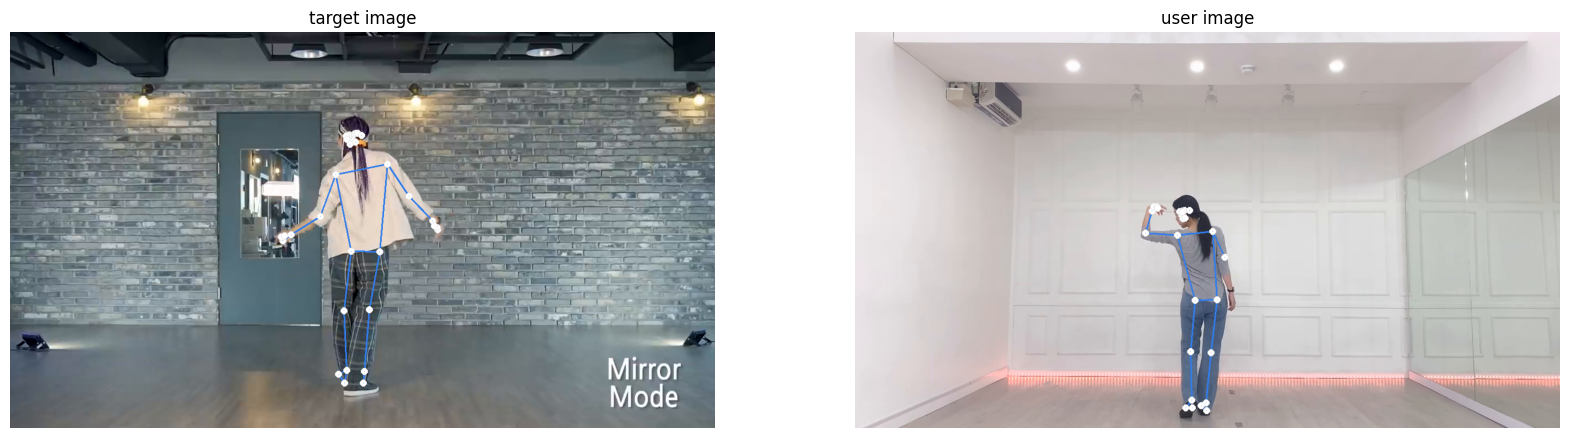

SVC: 17.17
RandomForest: 22.0
Logistic: 33.34
XGBoost: 0.66
유클리드 거리: 45.49


In [204]:
i = 7
img = video_clip.get_frame(i)
img2 = video_clip2.get_frame(i)

img, target_result = detectPose(img, pose_video, True, False)
img2, user_result = detectPose(img2, pose_video, True, False)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('target image')

axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title('user image')

plt.show()

print("SVC:", get_sim(target_result, user_result, svc))
print("RandomForest:", get_sim(target_result, user_result, RF))
print("Logistic:", get_sim(target_result, user_result, Logi))
print("XGBoost:", get_sim(target_result, user_result, XGB))
print("유클리드 거리:", dist_sim(target_result, user_result))

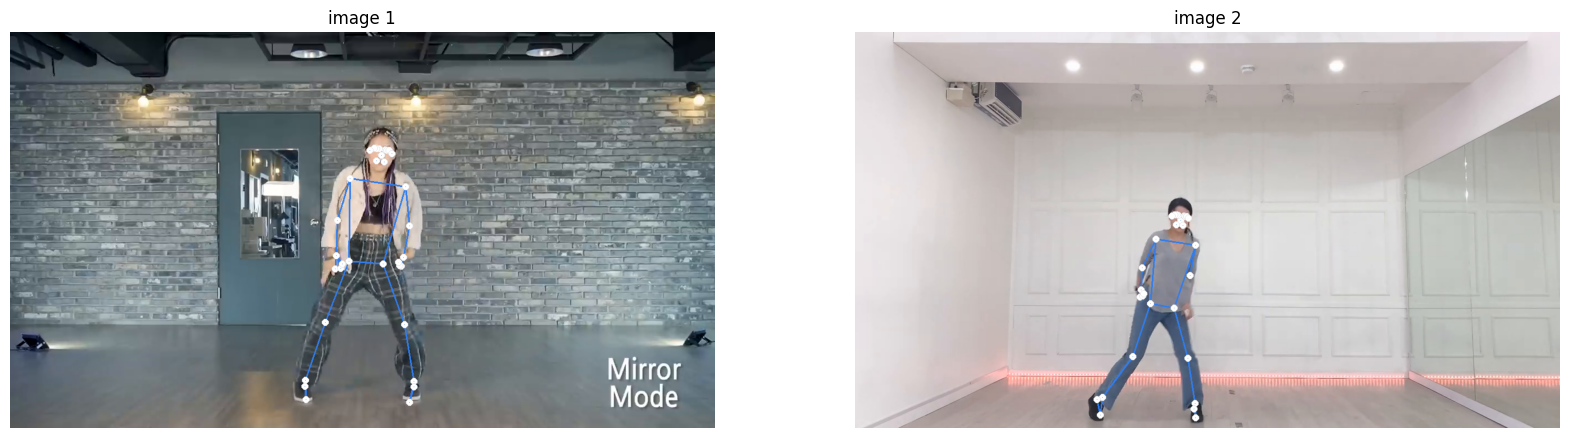

SVC: 66.19
RandomForest: 96.0
Logistic: 67.0
XGBoost: 99.76
유클리드 거리: 73.1


In [203]:
i = 32
img = video_clip.get_frame(i)
img2 = video_clip2.get_frame(i)

img, target_result = detectPose(img, pose_video, True, False)
img2, user_result = detectPose(img2, pose_video, True, False)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('image 1')

axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title('image 2')

plt.show()

print("SVC:", get_sim(target_result, user_result, svc))
print("RandomForest:", get_sim(target_result, user_result, RF))
print("Logistic:", get_sim(target_result, user_result, Logi))
print("XGBoost:", get_sim(target_result, user_result, XGB))
print("유클리드 거리:", dist_sim(target_result, user_result))

# 거리함수 이용 부위별 유사도

In [224]:
def dist_sim_part(target, user, part):
    # 좌표값 추출
    target_landmarks = target.pose_world_landmarks.landmark
    target_lm = np.array([[i.x, i.y, i.z] for i in target_landmarks])
    target_lm = target_lm[part, :]
    
    user_landmarks = user.pose_world_landmarks.landmark
    user_lm = np.array([[i.x, i.y, i.z] for i in user_landmarks])
    user_lm = user_lm[part, :]

    # 정규화
    scaler = MinMaxScaler()
    target_norm = scaler.fit_transform(target_lm)
    user_norm = scaler.fit_transform(user_lm)
    
    # 거리 구하기
    dis_x = distance.euclidean(target_norm[:, 0], user_norm[:, 0])
    dis_y = distance.euclidean(target_norm[:, 1], user_norm[:, 1])
    dis_z = distance.euclidean(target_norm[:, 2], user_norm[:, 2])
    
    # sim
    similarity = 1/(1+np.mean([dis_x, dis_y, dis_z]))
    
    return round(similarity * 100, 2)

In [209]:
i = 7
img = video_clip.get_frame(i)
img2 = video_clip2.get_frame(i)

img, target_result = detectPose(img, pose_video, True, False)
img2, user_result = detectPose(img2, pose_video, True, False)

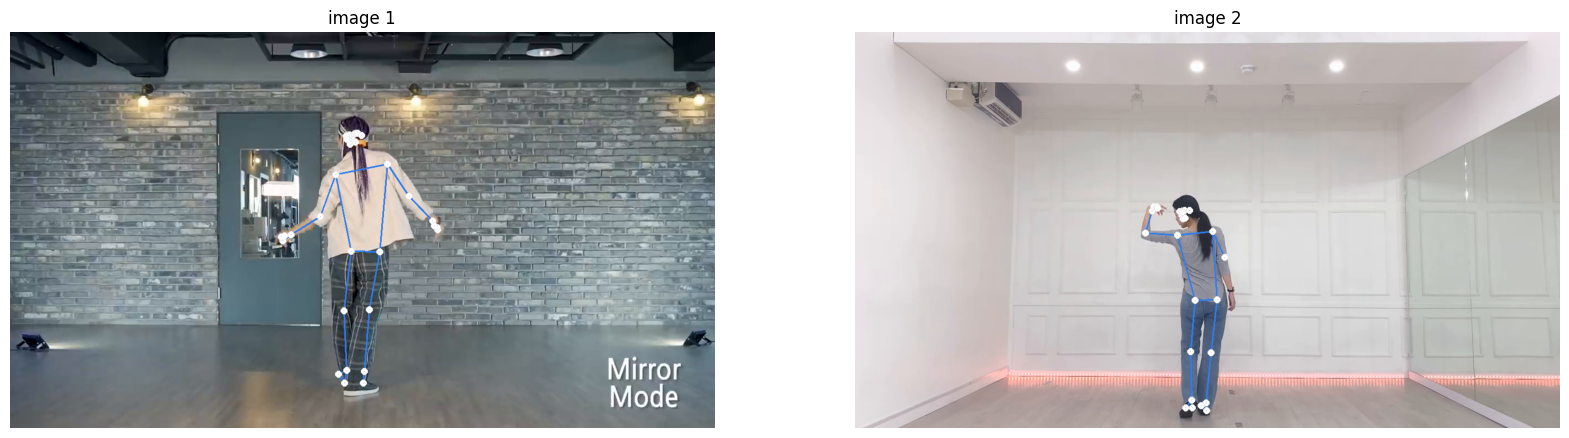

In [225]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('image 1')

axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title('image 2')

plt.show()

In [230]:
left_arm = [11, 13, 15, 17, 19, 21]
right_arm = [12, 14, 16, 18, 20, 22]
left_leg = [23, 25, 27, 29, 31]
right_leg = [24, 26, 28, 30, 32]
upper = range(11, 25)
under = range(23, 33)

print("왼팔:", dist_sim_part(target_result, user_result, left_arm))
print("오른팔:", dist_sim_part(target_result, user_result, right_arm))

print("왼다리:", dist_sim_part(target_result, user_result, left_leg))
print("오른다리:", dist_sim_part(target_result, user_result, right_leg))

print("상체:", dist_sim_part(target_result, user_result, upper))
print("하체:", dist_sim_part(target_result, user_result, under))

왼판: 49.83
오른팔: 55.67
왼다리: 77.68
오른다리: 72.02
상체: 45.69
하체: 72.65
